In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
# Function to set the seed for reproducibility
import random
def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if you are using multi-GPU.
    random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

    # The below two lines are for deterministic algorithm behavior in CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
set_seed()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def train_conditional_autoencoder(config):
    """Trains an autoencoder with the given configuration."""

    # Create the autoencoder model
    class Autoencoder(nn.Module):
        def __init__(self, encoder_layers, decoder_layers, activation, latent_dim):
            super(Autoencoder, self).__init__()

            # Encoder
            encoder_modules = []
            input_size = 784
            for layer_size in encoder_layers:
                encoder_modules.append(nn.Linear(input_size, layer_size))
                encoder_modules.append(activation())
                input_size = layer_size
            encoder_modules.append(nn.Linear(input_size, latent_dim))
            self.encoder = nn.Sequential(*encoder_modules)

            # Decoder
            #
            # NOTE: We add +10 here to include the label’s one-hot vector
            #       so the decoder sees [z || label_onehot].
            decoder_modules = []
            decoder_input_size = latent_dim + 10
            for layer_size in decoder_layers:
                decoder_modules.append(nn.Linear(decoder_input_size, layer_size))
                decoder_modules.append(activation())
                decoder_input_size = layer_size

            decoder_modules.append(nn.Linear(decoder_input_size, 784))
            decoder_modules.append(nn.Sigmoid())  # MNIST pixel intensities in [0,1]
            self.decoder = nn.Sequential(*decoder_modules)

        def forward(self, x, labels):
            """
            x: (batch_size, 784) Flattened MNIST images
            labels: (batch_size,) integer labels in [0..9], which we one-hot-encode
            """
            # Encode
            encoded = self.encoder(x)  # shape: (batch_size, latent_dim)

            # One-hot-encode labels, shape (batch_size, 10)
            labels_onehot = F.one_hot(labels, num_classes=10).float()

            # Concatenate z with the label’s one-hot: shape (batch_size, latent_dim + 10)
            z_cond = torch.cat([encoded, labels_onehot], dim=1)

            # Decode
            decoded = self.decoder(z_cond)
            return encoded, decoded

    model = Autoencoder(
        config['encoder_layers'],
        config['decoder_layers'],
        config['activation'],
        config['latent_dim']
    ).to(device)

    # Loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = config['epochs']
    loss_history = []  # store average loss per epoch

    for epoch in range(num_epochs):
        running_loss = 0.0
        for data in train_loader:
            inputs, labels = data
            inputs = inputs.view(-1, 784).to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            encoded, outputs = model(inputs, labels)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Compute average loss this epoch
        epoch_loss = running_loss / len(train_loader)
        loss_history.append(epoch_loss)
        print(f'Model: {config["name"]}, Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    return model, loss_history

In [ ]:
# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 487kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.79MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Image Shape :  torch.Size([1, 28, 28])
Image Data
tensor(0.) tensor(1.)
The pixel data ranges between 0 and 1.


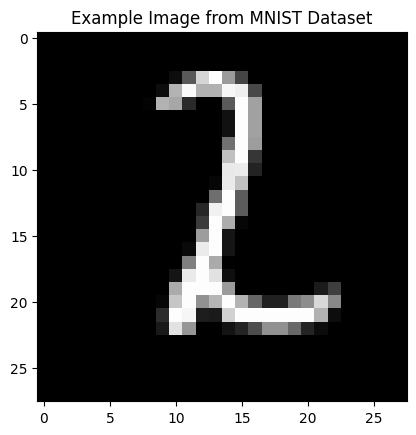

label:  2


In [ ]:
# Examine the result and real

# Get a batch of training data
images, labels = next(iter(train_loader))

# Select a random image from the batch
random_index = random.randint(0, len(images) - 1)
selected_image = images[random_index]
selected_label= labels[random_index]

print("Image Shape : ", selected_image.shape)
print("Image Data")
print(selected_image.min(), selected_image.max())
print("The pixel data ranges between 0 and 1.")

# Display the image
plt.imshow(selected_image.view(28, 28), cmap="gray")
plt.title("Example Image from MNIST Dataset")
plt.show()
print("label: ", selected_label.item())

In [ ]:
configs = [
    {'name': 'Model1', 'encoder_layers': [500, 100], 'decoder_layers': [100, 500], 'activation': nn.ReLU, 'latent_dim': 2, 'epochs': 10},
    {'name': 'Model2', 'encoder_layers': [500, 250, 100], 'decoder_layers': [100, 250, 500], 'activation': nn.ReLU, 'latent_dim': 2, 'epochs': 10},
    {'name': 'Model3', 'encoder_layers': [500, 100], 'decoder_layers': [100, 500], 'activation': nn.Sigmoid, 'latent_dim': 5, 'epochs': 10},
    {'name': 'Model4', 'encoder_layers': [500, 100], 'decoder_layers': [100, 500], 'activation': nn.Tanh, 'latent_dim': 10, 'epochs': 10},
     {'name': 'Model5', 'encoder_layers': [500, 250, 100], 'decoder_layers': [100, 250, 500], 'activation': nn.ReLU, 'latent_dim': 32, 'epochs': 10}, # Latent dim 32
    {'name': 'Model6', 'encoder_layers': [500, 250, 100], 'decoder_layers': [100, 250, 500], 'activation': nn.ReLU, 'latent_dim': 64, 'epochs': 10}, # Latent dim 64
]

In [ ]:
trained_models = {}
model_losses = {}  # to store loss curves

for config in configs:
    model, loss_hist = train_conditional_autoencoder(config)
    trained_models[config['name']] = model
    model_losses[config['name']] = loss_hist

    # Save the model
    torch.save(model.state_dict(), f"{config['name']}_model.pth")

Model: Model1, Epoch [1/10], Loss: 0.2436
Model: Model1, Epoch [2/10], Loss: 0.1826
Model: Model1, Epoch [3/10], Loss: 0.1722
Model: Model1, Epoch [4/10], Loss: 0.1686
Model: Model1, Epoch [5/10], Loss: 0.1666
Model: Model1, Epoch [6/10], Loss: 0.1651
Model: Model1, Epoch [7/10], Loss: 0.1640
Model: Model1, Epoch [8/10], Loss: 0.1630
Model: Model1, Epoch [9/10], Loss: 0.1622
Model: Model1, Epoch [10/10], Loss: 0.1616
Model: Model2, Epoch [1/10], Loss: 0.2438
Model: Model2, Epoch [2/10], Loss: 0.1768
Model: Model2, Epoch [3/10], Loss: 0.1694
Model: Model2, Epoch [4/10], Loss: 0.1661
Model: Model2, Epoch [5/10], Loss: 0.1640
Model: Model2, Epoch [6/10], Loss: 0.1626
Model: Model2, Epoch [7/10], Loss: 0.1614
Model: Model2, Epoch [8/10], Loss: 0.1604
Model: Model2, Epoch [9/10], Loss: 0.1597
Model: Model2, Epoch [10/10], Loss: 0.1590
Model: Model3, Epoch [1/10], Loss: 0.2663
Model: Model3, Epoch [2/10], Loss: 0.2374
Model: Model3, Epoch [3/10], Loss: 0.2172
Model: Model3, Epoch [4/10], Los

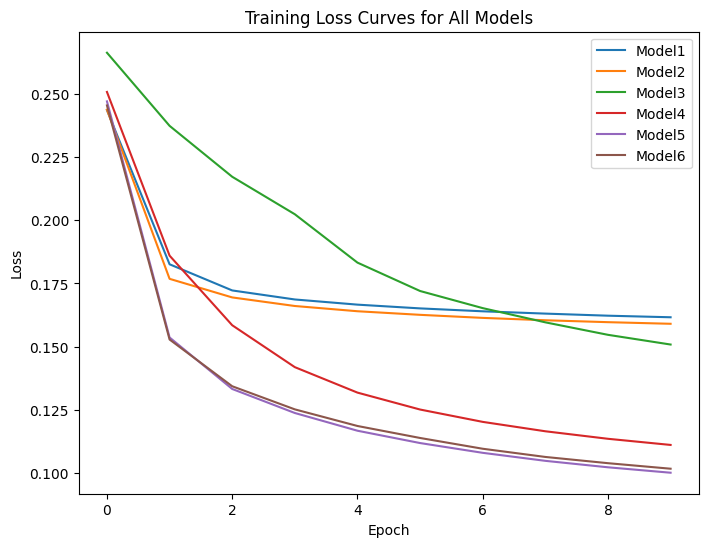

In [ ]:
import matplotlib.pyplot as plt

def plot_all_loss_curves(model_losses):
    """
    Plots the loss curve for each model in model_losses (dict: name -> loss_history).
    """
    plt.figure(figsize=(8,6))
    for model_name, losses in model_losses.items():
        plt.plot(losses, label=model_name)

    plt.title("Training Loss Curves for All Models")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Call this after you've trained all models
plot_all_loss_curves(model_losses)


Model 1,2 seem to have converged but the others nope, so let's add some more epochs

In [ ]:
def visualize_reconstructions(model, num_images=6):
    """
    Displays 'num_images' original images (top row) and their reconstructions (bottom row).
    """
    model.eval()
    # Grab one batch from the test_loader
    test_iter = iter(test_loader)
    images, labels = next(test_iter)

    # Move to device
    images = images.to(device)
    labels = labels.to(device)

    # Flatten images for the model
    flattened = images.view(-1, 784)

    # Forward pass
    with torch.no_grad():
        _, recon = model(flattened, labels)

    # Move back to CPU for plotting
    images = images.cpu()
    recon = recon.view(-1, 1, 28, 28).cpu()

    # Plot side-by-side
    fig, axes = plt.subplots(2, num_images, figsize=(num_images*2, 4))
    for i in range(num_images):
        # Original
        axes[0, i].imshow(images[i].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        # Reconstruction
        axes[1, i].imshow(recon[i].squeeze(), cmap='gray')
        axes[1, i].axis('off')

    plt.suptitle("Top: Original | Bottom: Reconstruction", y=1.02)
    plt.tight_layout()
    plt.show()


Visualizing Reconstructions for Model1...


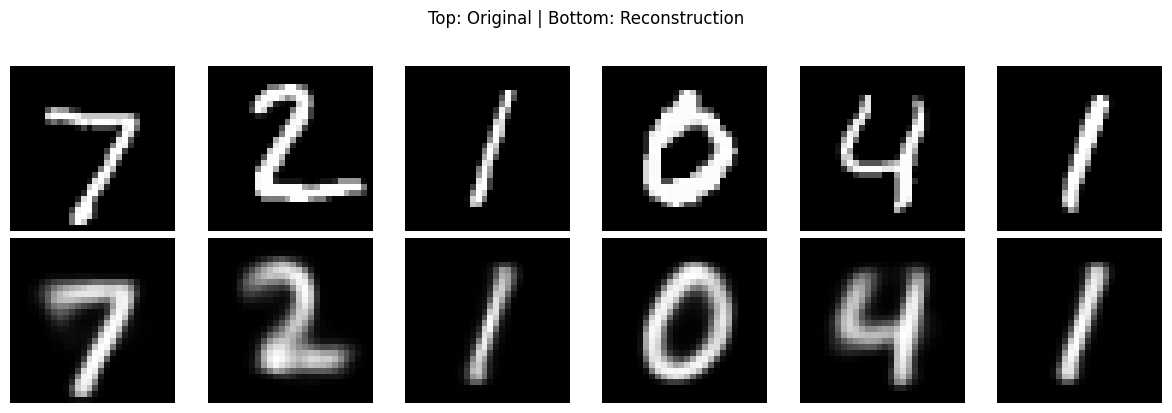

Visualizing Reconstructions for Model2...


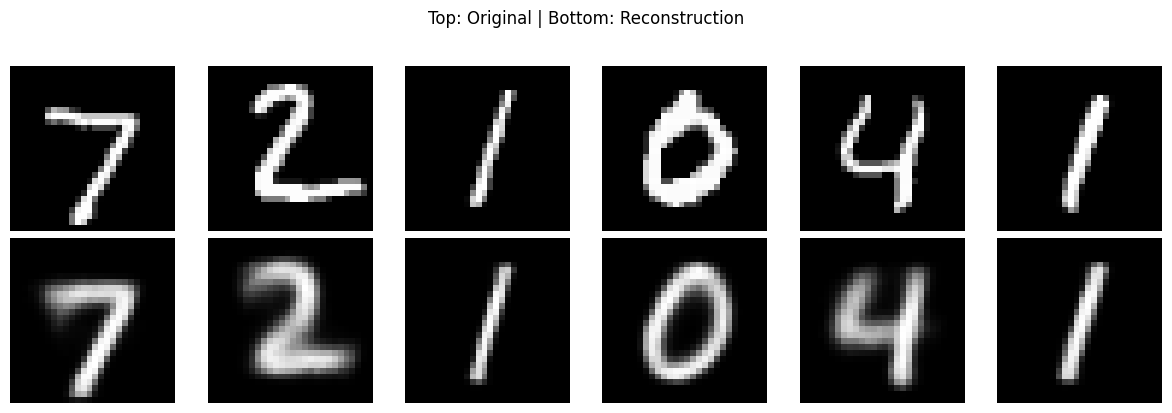

Visualizing Reconstructions for Model3...


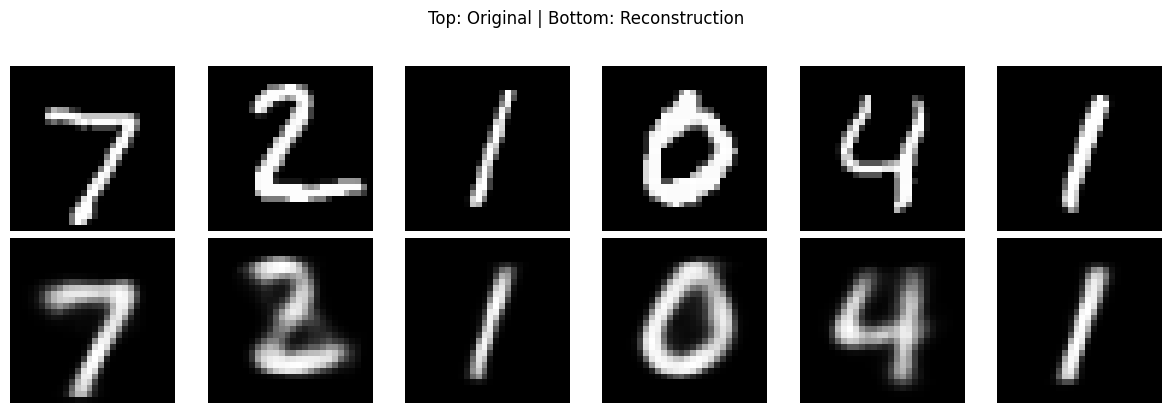

Visualizing Reconstructions for Model4...


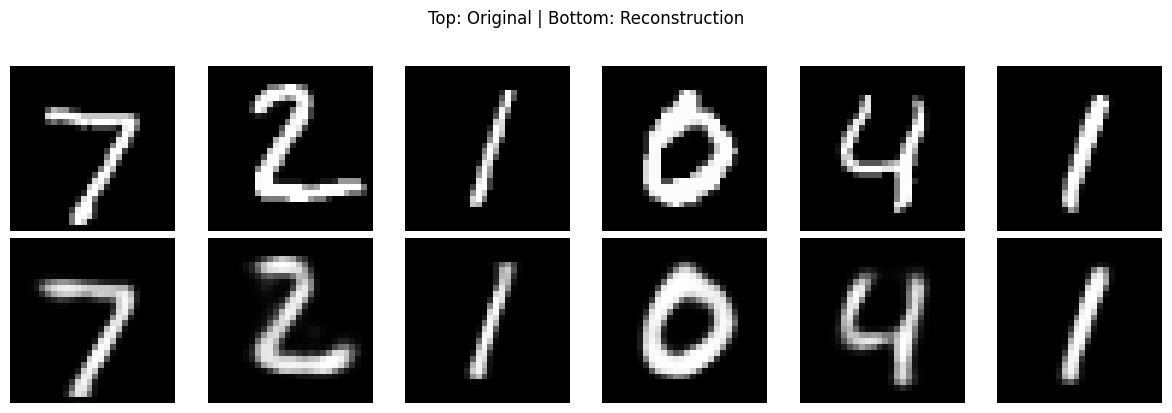

Visualizing Reconstructions for Model5...


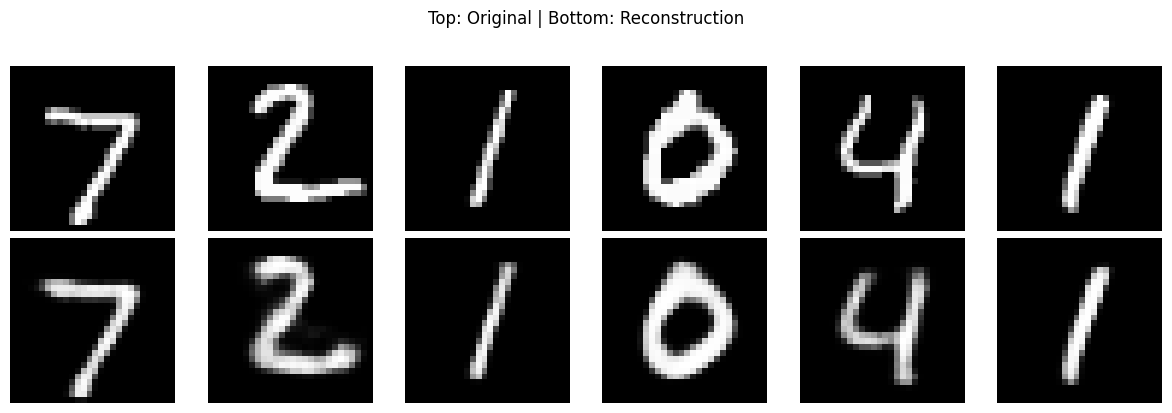

Visualizing Reconstructions for Model6...


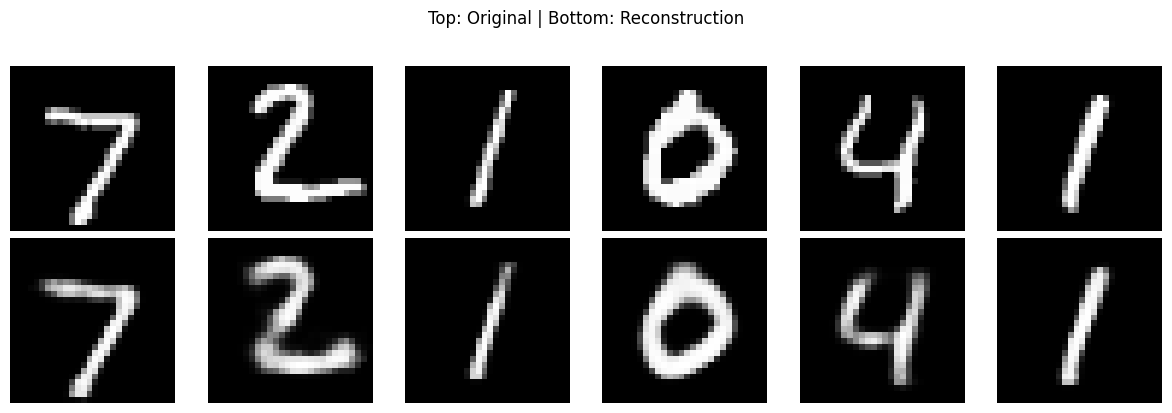

In [ ]:
for name, model in trained_models.items():
    print(f"Visualizing Reconstructions for {name}...")
    visualize_reconstructions(model, num_images=6)



=== Generations for Model1 ===


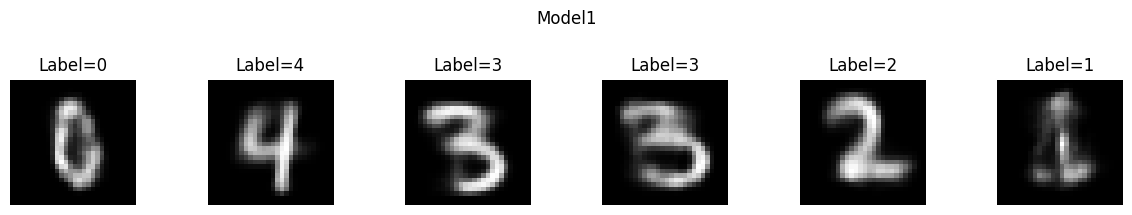


=== Generations for Model2 ===


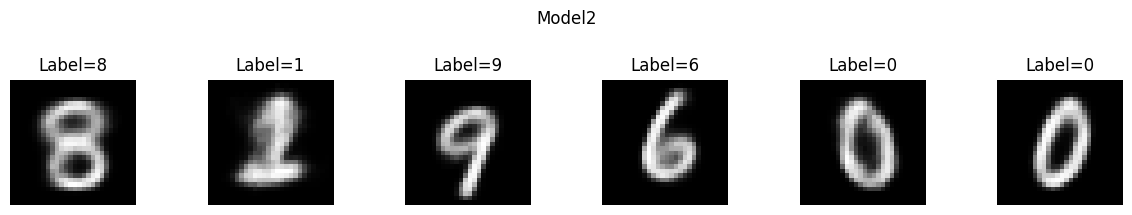


=== Generations for Model3 ===


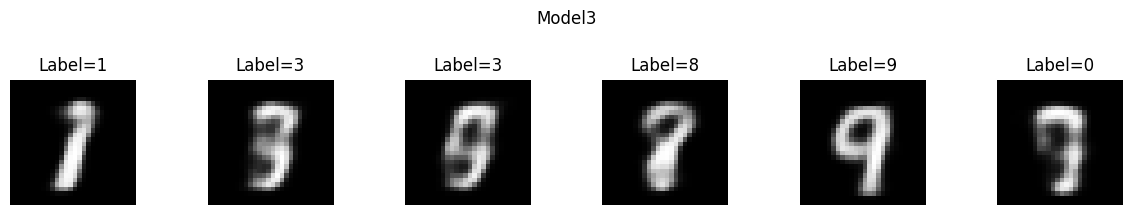


=== Generations for Model4 ===


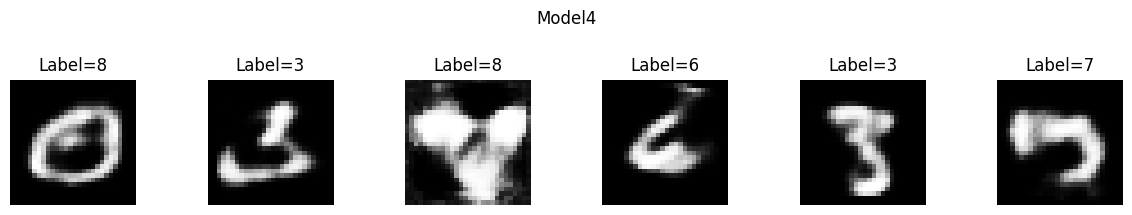


=== Generations for Model5 ===


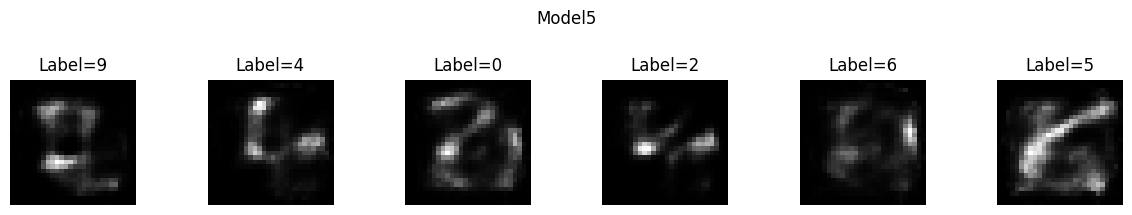


=== Generations for Model6 ===


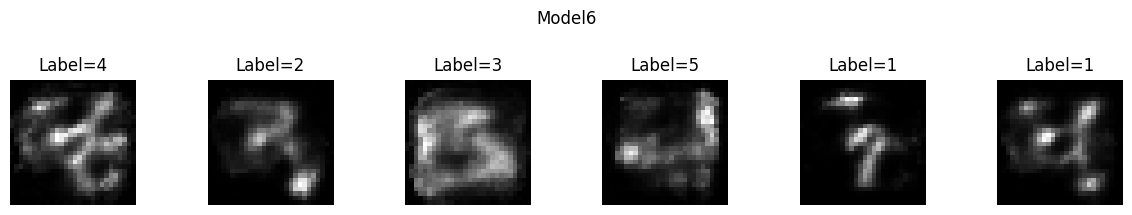

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

def generate_one_line_per_model(trained_models, device):
    """
    For each model in 'trained_models', generate 6 random digits in one row.
    """
    for model_name, model in trained_models.items():
        print(f"\n=== Generations for {model_name} ===")
        model.eval()

        # Create a figure with 1 row and 6 columns
        fig, axes = plt.subplots(1, 6, figsize=(12, 2))

        # We'll generate 6 random samples (columns)
        for i in range(6):
            # 1) Pick a random label in [0..9]
            rand_label = random.randint(0, 9)

            # 2) Get the latent_dim from the model's encoder
            latent_dim = model.encoder[-1].out_features

            # 3) Create a random latent vector z
            z = torch.randn(1, latent_dim).to(device)

            # 4) One-hot encode the chosen label
            label_onehot = F.one_hot(torch.tensor([rand_label], device=device), num_classes=10).float()

            # 5) Concatenate z + label_onehot and pass through decoder
            with torch.no_grad():
                z_cond = torch.cat([z, label_onehot], dim=1)
                generated = model.decoder(z_cond).cpu().view(28, 28)

            # 6) Display the result in a subplot
            axes[i].imshow(generated, cmap='gray')
            axes[i].set_title(f"Label={rand_label}")
            axes[i].axis("off")

        plt.suptitle(model_name, y=1.05)
        plt.tight_layout()
        plt.show()


# Example usage, assuming 'trained_models' and 'device' are defined:
generate_one_line_per_model(trained_models, device)


Below is a single-figure approach that (1) picks six random (latent_vector, label) pairs and (2) for each pair, passes it through all models side-by-side. This way, you see how each model responds to the same label + latent vector, across six different random draws.

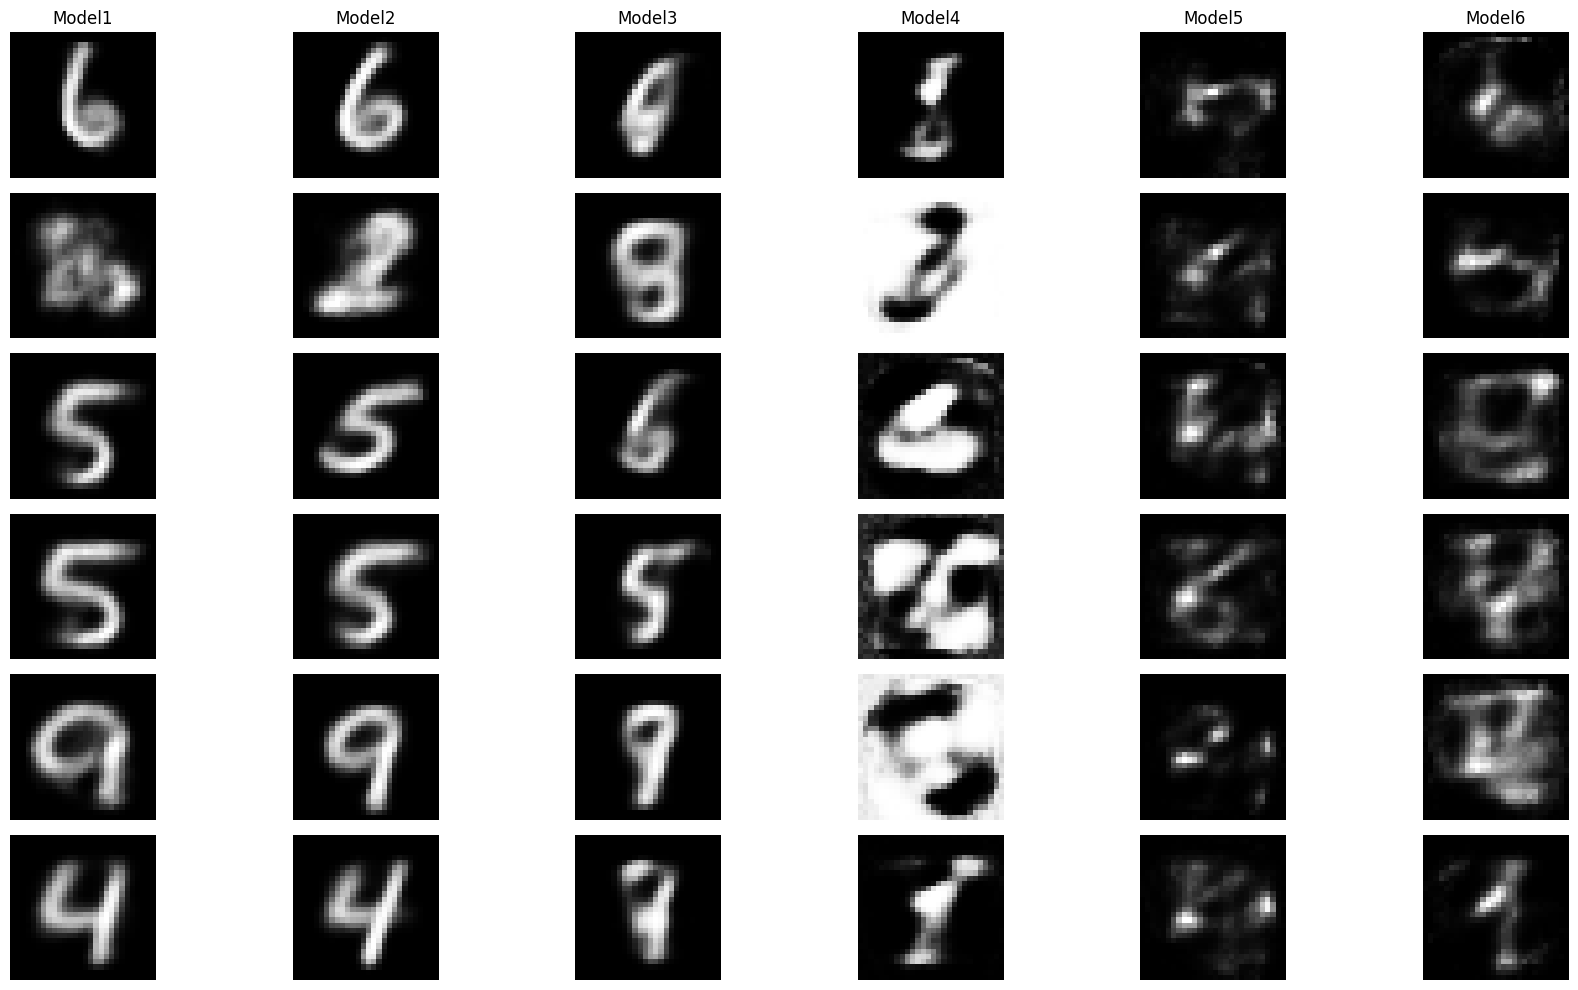

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

def compare_models_same_label_different_z(trained_models, device):
    """
    For each of 6 rows:
      - pick 1 random label
      - for each model, sample the correct latent_dim random z,
        decode [z || label_onehot], plot side-by-side.
    """
    # Convert trained_models to ordered lists for consistent plotting
    model_names = list(trained_models.keys())
    models = list(trained_models.values())
    num_models = len(models)

    # We'll generate 6 rows, each with num_models columns
    fig, axes = plt.subplots(nrows=6, ncols=num_models, figsize=(3 * num_models, 10))

    for row_idx in range(6):
        # 1) Pick a random label [0..9]
        rand_label = random.randint(0, 9)

        for col_idx, (model_name, model) in enumerate(trained_models.items()):
            model.eval()
            # 2) For this model, retrieve its latent_dim
            latent_dim = model.encoder[-1].out_features

            # 3) Sample a random latent vector
            z = torch.randn(1, latent_dim, device=device)

            # 4) One-hot encode the label
            label_onehot = F.one_hot(torch.tensor([rand_label], device=device), num_classes=10).float()

            # 5) Concatenate and decode
            z_cond = torch.cat([z, label_onehot], dim=1)
            with torch.no_grad():
                generated = model.decoder(z_cond).cpu().view(28, 28)

            # 6) Plot the result
            ax = axes[row_idx, col_idx] if num_models > 1 else axes[row_idx]
            ax.imshow(generated, cmap='gray')
            ax.axis('off')

            # Label the top row with the model name
            if row_idx == 0:
                ax.set_title(model_name)

        # Label the left axis with the random digit used for this row
        axes[row_idx, 0].set_ylabel(f"Label={rand_label}", rotation=90, labelpad=10)

    plt.tight_layout()
    plt.show()

# Example usage, assuming 'trained_models' and 'device' are defined:
compare_models_same_label_different_z(trained_models, device)



**1. Observed Issue**  
Models 3–6 reconstruct MNIST digits more accurately than Models 1–2 but don’t necessarily generate better images when sampling random latent vectors.

**2. Causes**  
- **Higher Capacity**: Models 3–6 have larger latent dimensions or deeper networks, helping them memorize (encode→decode) training digits with lower reconstruction error.  
- **No Latent Regularization**: Vanilla autoencoders do not constrain the latent space distribution; a random vector may fall outside the “learned manifold,” leading to poor-quality generations.

**3. Conclusion**  
While extra capacity improves reconstruction by fitting training samples more precisely, it doesn’t guarantee coherent outputs for random latent inputs in a standard autoencoder.